In [1]:
import sys
import os
os.environ['USE_PYGEOS'] = '0'
import gc
import collections
from pathlib import Path

import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rcParams, cycler
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import geopandas as gpd
from statsmodels.tsa.seasonal import seasonal_decompose


import numpy as np
import xarray as xr
from xeofs.xarray import EOF
import rioxarray

import dask
import distributed

import scipy
from scipy import signal
import cftime
from shapely.geometry import mapping
from xarrayutils.utils import linear_trend, xr_linregress
import pandas as pd
import cmocean

In [ ]:
dask.config.set(malloc_hook='jemalloc')

In [ ]:
# FIXIT: Jupyter Lab scheduler view for Dask not working
client = distributed.Client()
client

# Read dataset

In [2]:
# File path directories

# inDirName = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# Get full path of the aislens_emulation directory. All file IO is relative to this path.
main_dir = Path.cwd().parent
#dir_ext_data = 'data/external/'
#dir_interim_data = 'data/interim/'
DIR_external = 'data/external/'
DIR_processed = 'data/processed/'
FILE_MeltDraftObs = 'ANT_G1920V01_IceShelfMeltDraft.nc'
FILE_basalMeltObs_deSeasonalized = 'obs23_melt_anm.nc'
FILE_iceShelvesShape = 'iceShelves.geojson'

In [3]:
ICESHELVES_MASK = gpd.read_file(main_dir / DIR_external / FILE_iceShelvesShape)
icems = ICESHELVES_MASK.to_crs({'init': 'epsg:3031'});
crs = ccrs.SouthPolarStereo();

/Users/smurugan9/opt/anaconda3/envs/aislens/lib/python3.10/site-packages/pyproj/crs/crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [4]:
#MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs, chunks={"x":729, "y":729})
MELTDRAFT_OBS = xr.open_dataset(main_dir / DIR_external / FILE_MeltDraftObs)
obs23_melt = MELTDRAFT_OBS.melt
obs23_draft = MELTDRAFT_OBS.draft

# Time series of spatial mean melt
obs23_melt_ts = obs23_melt.mean(dim=['x', 'y'])#.compute()

# Time mean of melt rate and draft
obs23_melt_tm = obs23_melt.mean(dim='time')#.compute()
obs23_draft_tm = obs23_draft.mean(dim='time')#.compute()

In [ ]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot()
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations')
plt.ylabel('Melt rate (m/yr)')
plt.xlabel('Time (Year)')
plt.grid()

In [ ]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
obs23_melt_tm_vmin = np.nanquantile(obs23_melt_tm.values, 0.01)
obs23_melt_tm_vmax = np.nanquantile(obs23_melt_tm.values, 0.99)

# Plot figure

sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
ax1.coastlines(lw=0.2)

obs23_melt_tm.plot(ax=ax1, vmin=-abs(obs23_melt_tm_vmin)/4, vmax=abs(obs23_melt_tm_vmin)/4, cmap='RdBu_r', cbar_kwargs={'label': 'Basal melt rate (m/yr)'}, zorder=5)
plt.title('Mean ice shelf basal melt rate from satellite observations (1992-2017)')

In [ ]:
# Note the colorbar extent is set to half of the max of the 1% and 99% quantiles in the raw data variable for better visualization.
sns.set_theme(style="whitegrid")

plt.figure(figsize=(15,15))
ax1 = plt.subplot(111,projection=ccrs.SouthPolarStereo())

#icems[34:133].plot(ax=ax1,color='antiquewhite', linewidth=0,zorder=1)
#icems[34:133].boundary.plot(ax=ax1,color='k', linewidth=0.2,zorder=4)


#ax1.patch.set_facecolor(color='lightsteelblue')
#ax1.add_feature(cartopy.feature.LAND, color='ghostwhite', zorder=1)
# ax1.coastlines(lw=0.2)

(0-obs23_draft_tm).plot(ax=ax1, cmap=cmocean.cm.deep_r, cbar_kwargs={'label': 'Ice draft (m)'}, zorder=5)
plt.title('Ice draft underneath ice shelves (mean during 1992-2017)')

## Detrend dataset

The satellite observational dataset of basal melt rate is fit to a linear polynomial function to remove any inherent trend.

Interestingly, there is a bump in the linear trend in 2012 that should be explained, using Method 1 (naive).

The methodology for detrending has been tested/verified to be correct.

### Method 1 (*Per-pixel*)
Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point.

A first order polynomial fit is performed **on the raw 3 dimensional dataset** and this fit is subtracted from all pixel locations in the data.


### Method 2 (*Uniform*)
Detrend the time series of spatial mean melt rate using a mean linear trend that is uniform at all spatial points.

A first order polynomial fit (linear decomposition) is performed **on the spatially averaged dataset** (i.e., essentially a time series data), and this same fit is subtracted from all locations in the data.

In [5]:
def detrend_dim(data, dim, deg):
    # detrend along a single dimension
    p = data.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(data[dim], p.polyfit_coefficients)
    return data - fit

In [6]:
# Method 1: Detrend the time series of spatial mean melt rate using a linear trend that is unique at each spatial point
obs23_melt_detrend_perpixel = detrend_dim(obs23_melt, 'time', 1).compute()
obs23_melt_detrend_perpixel_ts = obs23_melt_detrend_perpixel.mean(dim=['x', 'y']).compute()

KeyboardInterrupt: 

In [7]:
# Method 2: Detrend the time series of spatial mean melt rate using a mean linear trend that is uniform at all spatial points
obs23_melt_detrend_ts = detrend_dim(obs23_melt_ts, 'time', 1)#.compute()
trendfit = obs23_melt_ts-obs23_melt_detrend_ts
# Subtract the above trendfit from the melt dataset to get the detrended melt dataset
obs23_melt_detrend_uniform = obs23_melt - trendfit
obs23_melt_detrend_uniform_ts = obs23_melt_detrend_uniform.mean(dim=['x', 'y'])#.compute()

In [ ]:
plt.subplots(1,2,figsize=(25,8), gridspec_kw={'width_ratios': [3, 1]})

plt.subplot(121)
obs23_melt_ts.plot(label='Original')
obs23_melt_detrend_perpixel_ts.plot(label='Detrended')
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit', lw=3, ls='--')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations (detrended)')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.axvspan(pd.Timestamp('2011-10-01'), pd.Timestamp('2012-05-01'), facecolor='red', alpha=0.2, label='Jump in melt rate trend?!')
plt.legend()

plt.subplot(122)
plt.plot(obs23_melt_ts-obs23_melt_detrend_perpixel_ts, lw=3, ls='--', color='green')
plt.xlabel('Time (Date Index)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Linear function fit for the melt rate time series trend')

In [ ]:
plt.subplots(1,2,figsize=(25,8), gridspec_kw={'width_ratios': [3, 1]})

plt.subplot(121)
obs23_melt_ts.plot(label='Original')
obs23_melt_detrend_uniform_ts.plot(label='Detrended with uniform linear trend across ice sheet')
obs23_melt_detrend_perpixel_ts.plot(label='Detrended with linear trend on a per-pixel basis')
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear Function Fit (uniform)', lw=3, ls='-')
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit (per-pixel)', lw=3, ls='--')
(obs23_melt_detrend_uniform_ts-obs23_melt_detrend_perpixel_ts).plot(label='Difference between the two detrending methods', lw=3, ls=':')
plt.title('Time series of spatially averaged ice shelf basal melt rate from satellite observations')
plt.xlabel('Time (Year)')
plt.ylabel('Melt rate (m/yr)')
plt.legend()

plt.subplot(122)
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot(label='Linear Function Fit (uniform)', lw=3, ls='-', color='C3') # uniform linear trend subtracted
(obs23_melt_ts-obs23_melt_detrend_perpixel_ts).plot(label='Linear Function Fit (per-pixel)', lw=3, ls='--', color='C4') # per-pixel linear trend subtracted
plt.xlabel('Time (Date Index)')
plt.ylabel('Melt rate (m/yr)')
plt.title('Linear function fit for the melt rate time series trend')

## RENAME

# obs23_melt_detrend_tmp_ts -> obs23_melt_detrend_uniform_ts
# obs23_melt_detrend_ts -> obs23_melt_detrend_perpixel_ts


We proceed with the detrending using **Method 2**, as it provides a "cleaner" trendline fit without the jump in 2012 for further pre-processing.

## Deseasonalize

Seasonal climatologies can be removed via two methods similar to the initial detrending step.
(1) On a per-pixel basis
(2) A uniform/average climatology

In [8]:
# Deseasonalize
# Remove climatologies to isolate anomalies / deseasonalize 
melt_month = obs23_melt_detrend_uniform.groupby("time.month")
melt_clm = melt_month.mean("time")#.compute() # Climatologies
obs23_melt_detrend_uniform_deseasonalize = melt_month - melt_clm # Deseasonalized anomalies

In [43]:
melt_month = obs23_melt_detrend_uniform_ts.groupby("time.month")
melt_clm = melt_month.mean("time")#.compute() # Climatologies
obs23_melt_detrend_uniform_deseasonalize_ts = melt_month - melt_clm # Deseasonalized anomalies

In [44]:
climfit = obs23_melt_detrend_uniform_ts - obs23_melt_detrend_uniform_deseasonalize_ts


In [45]:
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform - climfit

In [47]:
obs23_melt_detrend_uniform_deseasonalize_uniform.attrs['detrend_method'] = 'uniform linear trend across ice sheet'
obs23_melt_detrend_uniform_deseasonalize_uniform.attrs['deseason_method'] = 'uniform climatology across ice sheet'
obs23_melt_detrend_uniform_deseasonalize_uniform = obs23_melt_detrend_uniform_deseasonalize_uniform.rename('melt')

In [40]:
obs23_melt_detrend_uniform_deseasonalize.attrs['detrend_method'] = 'uniform linear trend across ice sheet'
obs23_melt_detrend_uniform_deseasonalize = obs23_melt_detrend_uniform_deseasonalize.rename('melt')

In [41]:
obs23_melt_detrend_uniform_deseasonalize.to_netcdf(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize.nc", engine='h5netcdf')

In [48]:
obs23_melt_detrend_uniform_deseasonalize_uniform.to_netcdf(main_dir / DIR_processed / "obs23_melt_detrend_uniform_deseasonalize_uniform.nc", engine='h5netcdf')

In [51]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts = obs23_melt_detrend_uniform_deseasonalize_uniform.mean(dim=['x', 'y'])#.compute()

In [ ]:
trend = obs23_melt_ts - obs23_melt_detrend_uniform_ts
clim = obs23_melt_detrend_uniform_ts-obs23_melt_detrend_uniform_deseasonalize_ts

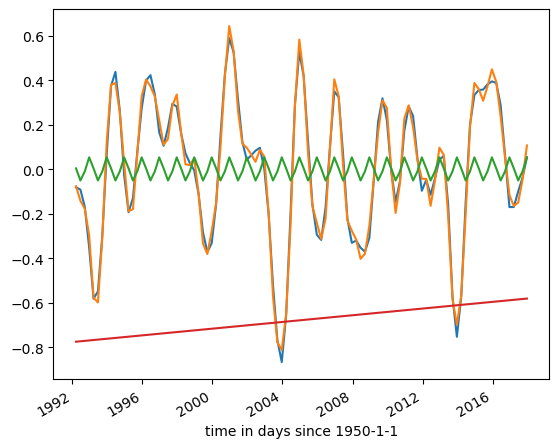

In [52]:
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot()
obs23_melt_detrend_uniform_ts.plot()
(obs23_melt_detrend_uniform_ts-obs23_melt_detrend_uniform_deseasonalize_ts).plot()
(obs23_melt_ts-obs23_melt_detrend_uniform_ts).plot()


In [ ]:
melt_anm.mean(["x", "y"]).plot()
obs23_melt.mean(["x", "y"]).plot()


In [ ]:
melt_anm.mean(["x", "y"]).plot()
obs23_melt_anm_ts.plot()

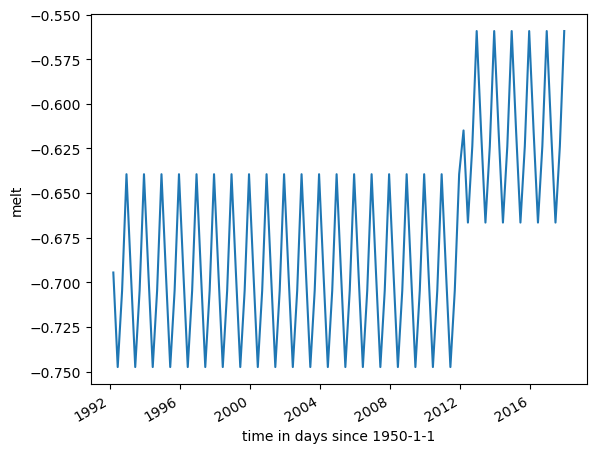

In [53]:
# Remove seasonality from the time series
# Check draft dependence on the residuals
# Check the residuals for spatial correlation

obs23_melt_anm = xr.open_dataset(main_dir / DIR_processed / FILE_basalMeltObs_deSeasonalized, chunks={"x":729, "y":729})
obs23_melt_anm_ts = obs23_melt_anm.melt.mean(dim=['x', 'y']).compute()

#obs23_melt_anm_ts.plot()
#obs23_melt_ts.plot()
(obs23_melt_ts-obs23_melt_anm_ts).plot()


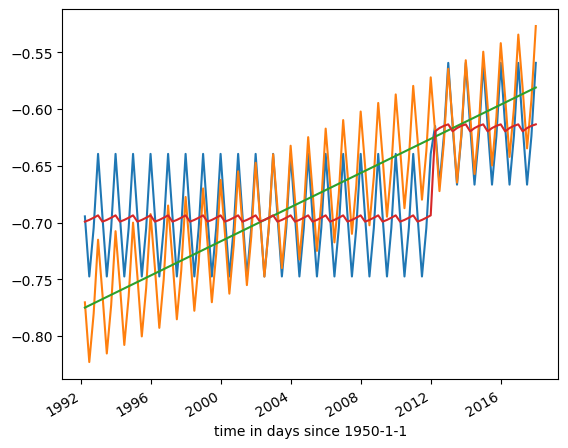

In [63]:
(obs23_melt_ts-obs23_melt_anm_ts).plot()
(climfit+trendfit).plot()
trendfit.plot()
(-climfit+obs23_melt_ts-obs23_melt_anm_ts).plot()

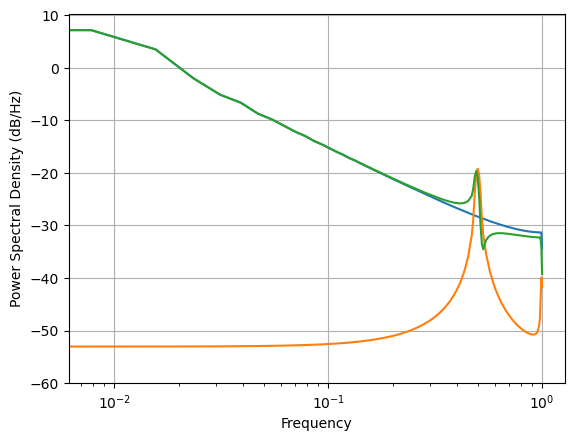

In [80]:
plt.psd(trendfit);
plt.psd(climfit);
plt.psd(trendfit+climfit);
plt.xscale('log')
# plt.psd(obs23_melt_ts-obs23_melt_anm_ts);

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(obs23_melt_tm, obs23_draft_tm)
plt.ylim(2500,0)

In [ ]:
# Deseasonalize: Remove climatologies to isolate anomalies / deseasonalize
obs23_melt_month = obs23_melt.groupby("time.month")
obs23_melt_clm = obs23_melt_month.mean("time").compute() # Climatologies
obs23_melt_anm = (obs23_melt_month - obs23_melt_clm).compute() # Deseasonalized anomalies

In [ ]:
obs23_melt_anm_ts = obs23_melt_anm.mean(['x', 'y']).compute()

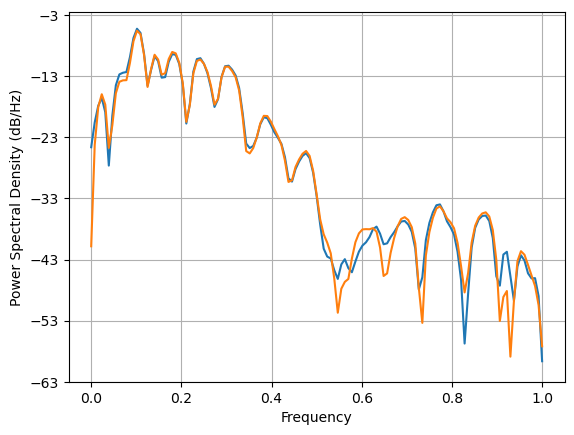

In [71]:
plt.psd(obs23_melt_anm_ts);
plt.psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);


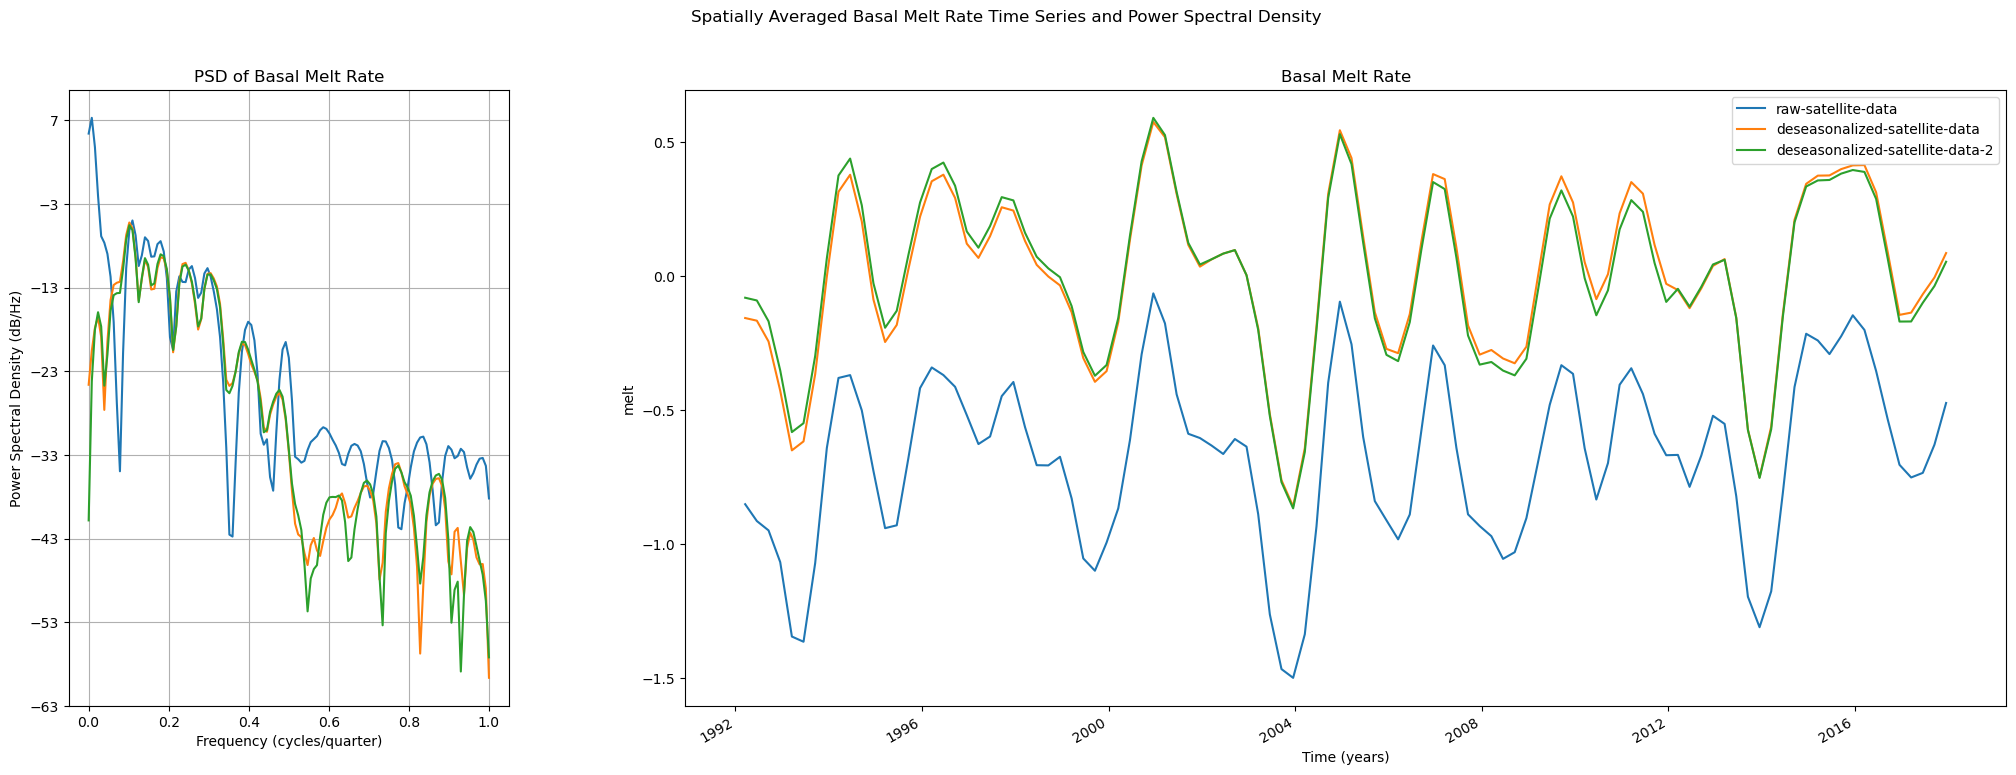

In [69]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_anm_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_anm_ts.plot(ax=axs[1], label='deseasonalized-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-satellite-data-2')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

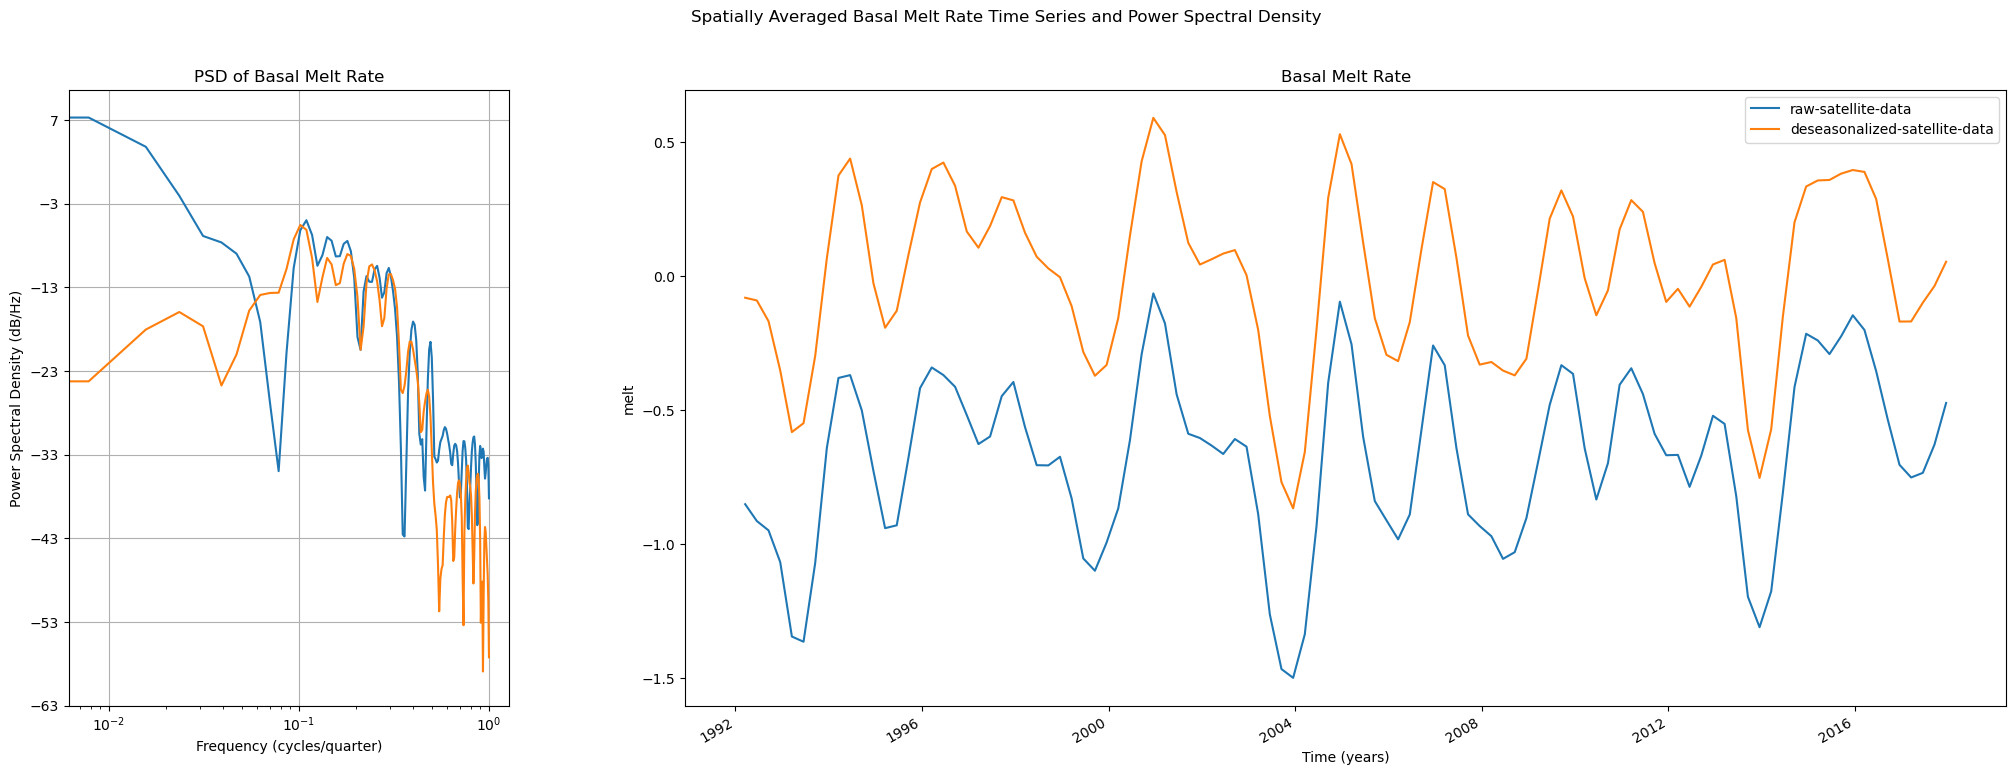

In [66]:
fig, axs = plt.subplots(1, 2, figsize=(25, 8), gridspec_kw={'width_ratios': [1, 3]})

axs[0].psd(obs23_melt_ts);
axs[0].psd(obs23_melt_detrend_uniform_deseasonalize_uniform_ts);
axs[0].set_xlabel('Frequency (cycles/quarter)')
axs[0].set_xscale('log')
axs[0].set_title('PSD of Basal Melt Rate')

obs23_melt_ts.plot(ax=axs[1], label='raw-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(ax=axs[1], label='deseasonalized-satellite-data')
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()
fig.suptitle('Spatially Averaged Basal Melt Rate Time Series and Power Spectral Density')
plt.show()

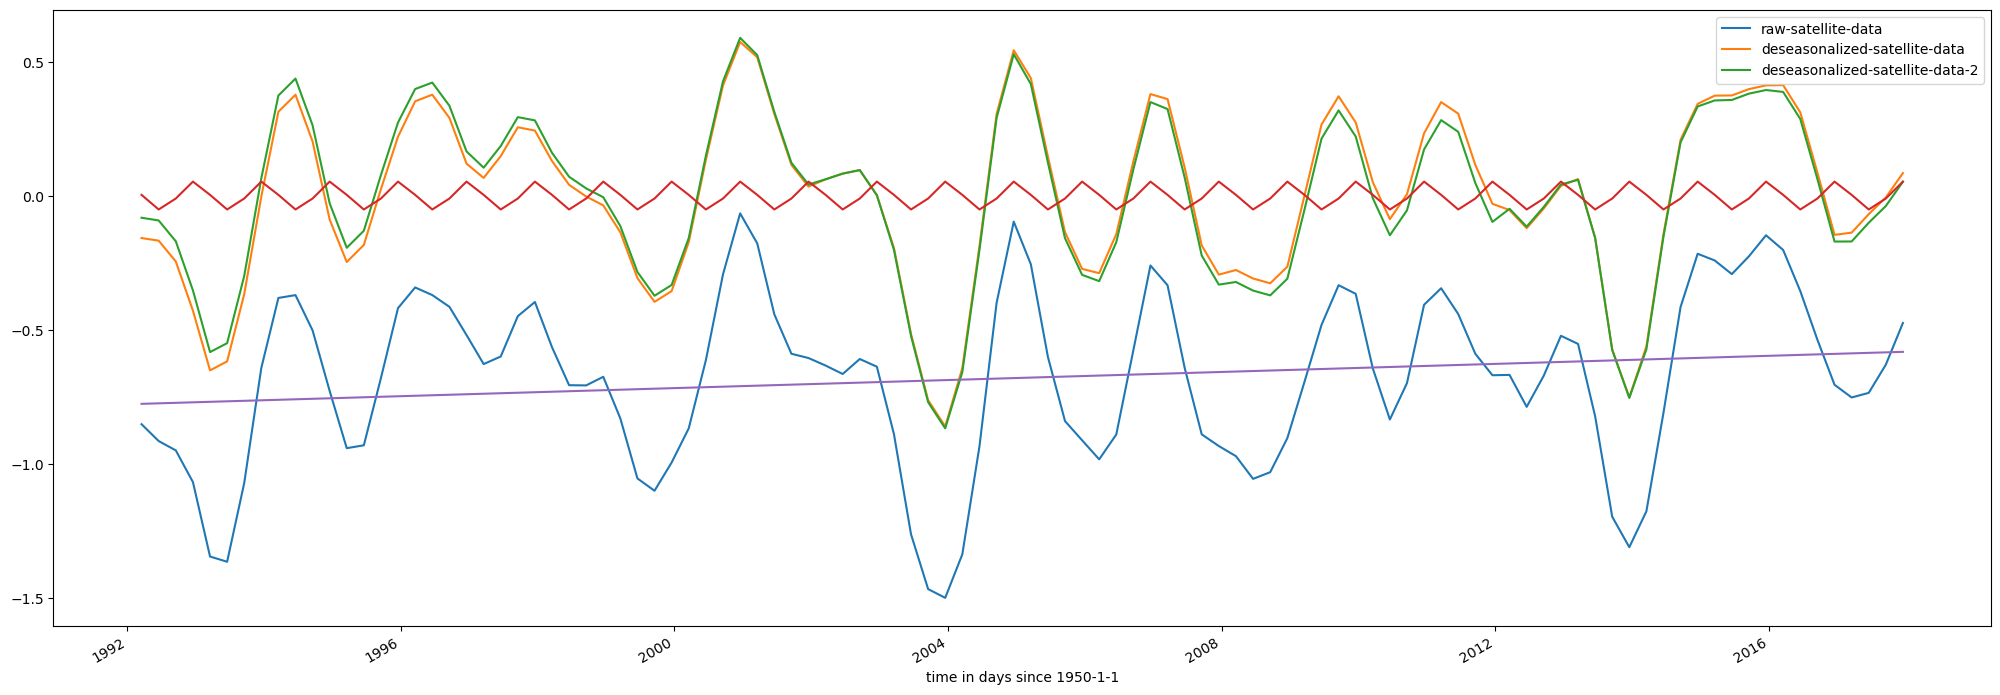

In [84]:
plt.figure(figsize=(25,8))
obs23_melt_ts.plot(label='raw-satellite-data')
obs23_melt_anm_ts.plot(label='deseasonalized-satellite-data')
obs23_melt_detrend_uniform_deseasonalize_uniform_ts.plot(label='deseasonalized-satellite-data-2')
#(obs23_melt_ts - obs23_melt_anm_ts).plot(label='climatology')
climfit.plot()
trendfit.plot()
#axs[1].plot(obs23_melt_ts)
axs[1].set_xlabel('Time (years)')
axs[1].set_title('Basal Melt Rate')

plt.legend()

In [ ]:
seasonal_decompose(obs23_melt_ts, model='additive', period=4).plot();

In [ ]:
# Spatial mean of the deseasonalized melt rate
obs23_melt_anm_tm = obs23_melt_anm.mean(dim='time').compute()

In [ ]:
plt.figure(figsize=(15,10))
plt.scatter(obs23_melt_anm_tm, obs23_draft_tm)
plt.ylim(2500,0)

In [ ]:
obs23_melt_anm_tm.rio.write_crs("epsg:3031",inplace=True);
obs23_draft_tm.rio.write_crs("epsg:3031",inplace=True);

obs23_melt_tm.rio.write_crs("epsg:3031",inplace=True);


In [ ]:
def clip_data(total_data, basin):
    clipped_data = total_data.rio.clip(icems.loc[[basin],'geometry'].apply(mapping),icems.crs)
    #clipped_data = clipped_data.dropna('time',how='all')
    #clipped_data = clipped_data.dropna('y',how='all')
    #clipped_data = clipped_data.dropna('x',how='all')
    #clipped_data = clipped_data.drop("month")
    return clipped_data

In [ ]:
IMBIEregions = range(6,33)
iceShelfRegions = range(33,133)

iceShelfRegions = range(6,16)

for i in iceShelfRegions:
    print('extracting data for catchment {}'.format(icems.name.values[i]))
    mltanm = clip_data(obs23_melt_tm, i)
    z = clip_data(obs23_draft_tm, i)
    plt.scatter(mltanm, z, marker='x', s=3)
    plt.ylim(2500,0)
    del mltanm, z
    print('deleted interim variables')
    gc.collect()

In [ ]:
# will need to use relative drafts here?